In [9]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
x_train = mnist.train.images[:55000,:]
x_train.shape

(55000, 784)

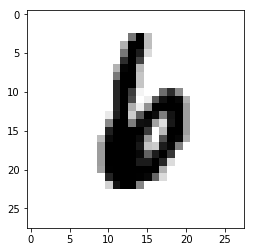

In [12]:
randomNum = random.randint(0,55000)
image = x_train[randomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [13]:
def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [14]:
def discriminator(x_image, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()
    #First Conv and Pool Layers
    W_conv1 = tf.get_variable('d_wconv1', [5, 5, 1, 8], initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = avg_pool_2x2(h_conv1)

    #Second Conv and Pool Layers
    W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = avg_pool_2x2(h_conv2)

    #First Fully Connected Layer
    W_fc1 = tf.get_variable('d_wfc1', [7 * 7 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    #Second Fully Connected Layer
    W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

    #Final Layer
    y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y_conv

In [15]:
def generator(z, batch_size, z_dim, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()
    g_dim = 64 #Number of filters of first layer of generator 
    c_dim = 1 #Color dimension of output (MNIST is grayscale, so c_dim = 1 for us)
    s = 28 #Output size of the image
    s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16) #We want to slowly upscale the image, so these values will help
                                                              #make that change gradual.

    h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
    h0 = tf.nn.relu(h0)
    #Dimensions of h0 = batch_size x 2 x 2 x 25

    #First DeConv Layer
    output1_shape = [batch_size, s8, s8, g_dim*4]
    W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                              initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
    H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, strides=[1, 2, 2, 1], padding='SAME')
    H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
    H_conv1 = tf.nn.relu(H_conv1)
    #Dimensions of H_conv1 = batch_size x 3 x 3 x 256

    #Second DeConv Layer
    output2_shape = [batch_size, s4 - 1, s4 - 1, g_dim*2]
    W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                              initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
    H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, strides=[1, 2, 2, 1], padding='SAME')
    H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
    H_conv2 = tf.nn.relu(H_conv2)
    #Dimensions of H_conv2 = batch_size x 6 x 6 x 128

    #Third DeConv Layer
    output3_shape = [batch_size, s2 - 2, s2 - 2, g_dim*1]
    W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                              initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
    H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, strides=[1, 2, 2, 1], padding='SAME')
    H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
    H_conv3 = tf.nn.relu(H_conv3)
    #Dimensions of H_conv3 = batch_size x 12 x 12 x 64

    #Fourth DeConv Layer
    output4_shape = [batch_size, s, s, c_dim]
    W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                              initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
    H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, strides=[1, 2, 2, 1], padding='VALID')
    H_conv4 = tf.nn.tanh(H_conv4)
    #Dimensions of H_conv4 = batch_size x 28 x 28 x 1

    return H_conv4

In [16]:
sess = tf.Session()
z_dimensions = 100
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [17]:
sample_image = generator(z_test_placeholder, 1, z_dimensions)
test_z = np.random.normal(-1, 1, [1,z_dimensions])

In [18]:
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

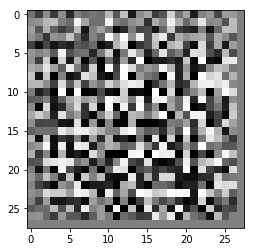

In [19]:
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')

In [20]:
batch_size = 16
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()
x_placeholder = tf.placeholder("float", shape = [None,28,28,1]) #Placeholder for input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) #Placeholder for input noise vectors to the generator

In [21]:
Dx = discriminator(x_placeholder) #Dx will hold discriminator prediction probabilities for the real MNIST images
Gz = generator(z_placeholder, batch_size, z_dimensions) #Gz holds the generated images
Dg = discriminator(Gz, reuse=True) #Dg will hold discriminator prediction probabilities for generated images

In [22]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(Dg, tf.ones_like(Dg)))  

ValueError: Only call `sigmoid_cross_entropy_with_logits` with named arguments (labels=..., logits=..., ...)